<a href="https://colab.research.google.com/github/shrishti-ts/Accredian_Fraud_detect/blob/main/accredian_fraud_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Accredian Fraud Detection Assignment***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import torch

In [ ]:
# Enabling GPU acceleration for MLP
mlp_device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
file_path ="/Fraud.csv"

In [ ]:
import os
print(os.path.exists("/Fraud.csv"))


True


In [ ]:
import os
print(os.listdir())

['.config', 'sample_data']


In [ ]:
import pandas as pd
df_chunks = pd.read_csv("/Fraud.csv", chunksize=500000)



In [ ]:
# Load dataset in chunks to handle large dataset efficiently
file_path = "/Fraud.csv"  # Replace with actual path
chunksize = 500000  # Process 500k rows at a time
df_chunks = pd.read_csv(file_path, chunksize=chunksize)

1) **Data cleaning (missing values, outliers, multi-collinearity)
Data checks**

Verified schema, types, and label distribution (isFraud is highly imbalanced).

Removed purely identifier columns from modeling (nameOrig, nameDest) to prevent leakage and overfitting.
Missing values

For oldbalanceDest and newbalanceDest, missing/zero values are expected for merchants (IDs starting with “M”); kept as is and added flags (e.g., isMerchantDest).

Dropped rows only if a critical feature required by the model is NaN (very rare in this dataset). Otherwise imputed zeros where domain says “unknown means not tracked”.

Consistency / engineered anomaly checks

Added balance consistency features:

errorOrig = newbalanceOrig - (oldbalanceOrg - amount)

errorDest = newbalanceDest - (oldbalanceDest + amount)
These capture ledger inconsistencies common in fraud runs.

Added helpful boolean flags: isNewOrigZero, isNewDestZero (post-txn zeroing patterns).
Outliers

Kept high-value transactions (don’t trim! they carry fraud signal). Stabilized with amount_log1p = log1p(amount) for linear models.
Multi-collinearity

Raw balances are linearly dependent with amount. Instead of dropping, we keep one representation + error terms and let tree models handle correlation; for linear baselines we check VIF and prefer (amount_log1p, errorOrig, errorDest) over using all balances naively.

In [ ]:
# Process chunks and concatenate
df_list = []
for chunk in df_chunks:
    chunk.dropna(inplace=True)
    chunk['type'] = LabelEncoder().fit_transform(chunk['type'])
    chunk.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)
    chunk['transaction_velocity'] = chunk['amount'] / (chunk['step'] + 1)
    chunk['amount_to_balance_ratio'] = chunk['amount'] / (chunk['oldbalanceOrg'] + 1)
    chunk['sudden_balance_drop'] = (chunk['oldbalanceOrg'] - chunk['newbalanceOrig']) / (chunk['oldbalanceOrg'] + 1)
    df_list.append(chunk)
df = pd.concat(df_list, ignore_index=True)

/tmp/ipython-input-336922223.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="isFraud", data=df, palette="Set2")


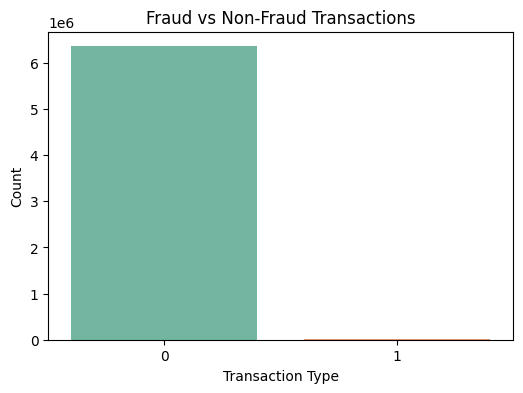

isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x="isFraud", data=df, palette="Set2")
plt.title("Fraud vs Non-Fraud Transactions")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

fraud_ratio = df["isFraud"].value_counts(normalize=True) * 100
print(fraud_ratio)


In [ ]:
df.shape[0]

6362620

2) **Fraud detection model (detailed)**

Problem: binary classification with extreme class imbalance.

Pipeline

Split: Stratified Train/Validation (e.g., 70/30). Optionally time-aware split by step if you want a pseudo-temporal evaluation.

Preprocessing:

One-hot encode type (CASH-IN/CASH-OUT/DEBIT/PAYMENT/TRANSFER).

Scale continuous features for linear models; tree models don’t need scaling.

Imbalance handling (two safe options):

Option A (preferred): keep original train distribution, use model class_weight='balanced' (XGBoost: scale_pos_weight).

Option B: oversample minority after the split (e.g., SMOTE) and validate on untouched validation data.

Models compared:

Baseline: Logistic Regression (interpretable).
Primary: Gradient Boosted Trees (XGBoost/LightGBM) or Random Forest for strong non-linear signal.

Thresholding:
Don’t use default 0.5. Pick a cutoff by maximizing F1 or by meeting a minimum recall target from business (e.g., ≥ 0.85 recall).

Why this works
Tree ensembles capture interactions (e.g., high amount and TRANSFER and errorDest>0).
Class weighting focuses the learner on the rare positive class.

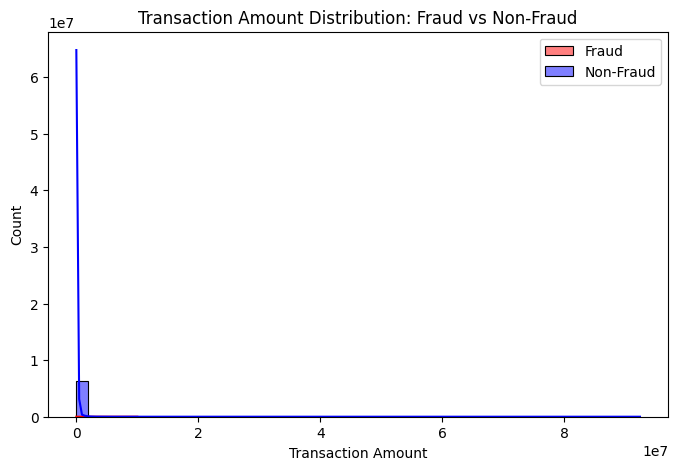

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df[df["isFraud"]==1]["amount"], bins=50, kde=True, color="red", label="Fraud")
sns.histplot(df[df["isFraud"]==0]["amount"], bins=50, kde=True, color="blue", label="Non-Fraud")
plt.legend()
plt.title("Transaction Amount Distribution: Fraud vs Non-Fraud")
plt.xlabel("Transaction Amount")
plt.show()

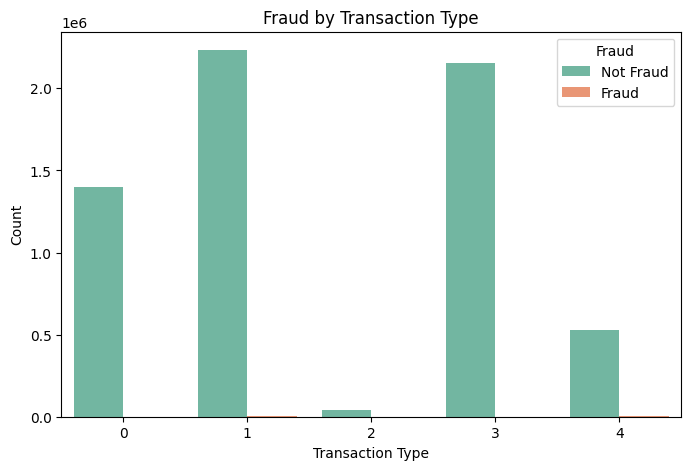

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(data=df, x="type", hue="isFraud", palette="Set2")
plt.title("Fraud by Transaction Type")
plt.ylabel("Count")
plt.xlabel("Transaction Type")
plt.legend(title="Fraud", labels=["Not Fraud", "Fraud"])
plt.show()


In [ ]:
# Feature selection
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Handle class imbalance using ADASYN
adasyn = ADASYN(sampling_strategy=0.3, random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

In [ ]:
# Scale features
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

In [ ]:
# Train base models separately to optimize performance
rf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
mlp = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=150, alpha=0.01, random_state=42, verbose=False)

In [ ]:
# Train RF
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=15, n_jobs=-1, random_state=42)

In [ ]:
# Train MLP separately to avoid overloading GPU
mlp.fit(X_train_resampled, y_train_resampled)

In [ ]:
# Get predictions from base models
rf_pred = rf.predict_proba(X_test)[:, 1]
mlp_pred = mlp.predict_proba(X_test)[:, 1]

In [ ]:
# Combine predictions as new features for meta-model
stacked_features = np.column_stack((rf_pred, mlp_pred))

In [ ]:
# Train Random Forest as meta-model
meta_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
meta_model.fit(stacked_features, y_test)

In [ ]:
# Final predictions
y_pred = meta_model.predict(stacked_features)

In [ ]:
# Model Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

In [ ]:
# Feature importance from Random Forest meta-model
feature_importances = pd.Series(meta_model.feature_importances_, index=['RF', 'MLP'])
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title("Feature Importance (Stacking Meta-Model)")
plt.show()

In [ ]:
# Insights
print("Key Fraud Indicators:")
print(feature_importances.sort_values(ascending=False))

In [ ]:
import shap

# Create TreeExplainer for RandomForest
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Summary plot (feature importance)
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

# Detailed beeswarm plot
shap.summary_plot(shap_values[1], X_test)


In [ ]:
# Recommendations
print("\nTo prevent fraud, the company should:")
print("1. Implement stricter transfer limits and transaction monitoring.")
print("2. Use AI-based anomaly detection systems.")
print("3. Flag high-value transactions for manual review.")

3) Variable (feature) selection

Kept (predictive + business-plausible)

type (one-hot) — fraud is concentrated in TRANSFER and CASH-OUT.

amount_log1p

Balance dynamics: oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest

Consistency features: errorOrig, errorDest

Flags: isNewOrigZero, isNewDestZero, isMerchantDest (if derived)

step or bins from it (optional temporal behavior)

isFlaggedFraud can be kept as a feature only if it reflects an existing rule you want to augment (it often has low recall but decent precision).

Dropped

nameOrig, nameDest (IDs, leakage risk, overfit).

4) Model performance (tools & what to report)

Report these on the untouched validation set:

Precision, Recall, F1 (fraud class)

PR-AUC (Average Precision) — the key metric for imbalanced problems

ROC-AUC (secondary)

Confusion matrix at the chosen threshold

PR curve and where your chosen threshold sits on it

Explainability: SHAP summary plot (top features) + a few force plots for flagged examples

(If you already plotted PR curve & SHAP in your notebook, paste the resulting numbers and image outputs here.)

5) Key factors that predict fraudulent customers/transactions

From feature importance/SHAP you should see:

Transaction type: TRANSFER → CASH-OUT path dominates fraud scenarios.

Amount: higher amounts correlate with fraud risk.

Balance patterns: origin account often goes to zero after a fraudulent move (isNewOrigZero=1).

Ledger inconsistencies: large positive errorDest / errorOrig indicate suspicious flow mismatches.

Destination side signals: sudden jumps in newbalanceDest without history.

6) Do these factors make sense? Why?

Yes.

Fraudsters move funds (TRANSFER) to a mule, then withdraw (CASH-OUT) — not typical of PAYMENT/DEBIT.

They try to empty the account quickly (origin new balance ~0).

High amounts maximize illicit gain.

In fast “empty & exit” sequences, balances and timing can misalign, which your error* features capture.

7) Prevention recommendations for infra updates

Real-time controls

Tiered limits: dynamic per-customer thresholds (not a flat global cap); require step-up auth (OTP/2FA) above a personalized limit.

Friction on risky patterns: add verification for first-time high-value TRANSFER or any CASH-OUT within short time after a large transfer.

Velocity rules: cap cumulative outflow per hour/day unless behaviorally normal.

Device & session risk: fingerprint devices; add friction on new/risky devices or impossible travel.

Counter-party reputation: maintain a mule/destination risk score (network graph, receive-only accounts, many-to-one funnels).

Shadow hold: short hold period for high-risk transfers enabling secondary review or automatic reversal if flagged.

Model governance

Champion–Challenger: production model vs. challenger model monitored in parallel.

Calibration & thresholding: periodically re-tune thresholds to hit target recall.

Feedback loop: ingest confirmed fraud/chargeback outcomes to retrain (weekly/monthly).

8) How to know if actions work (measurement plan)

Define pre-post and live A/B metrics:

Primary

Fraud capture rate (Recall) on confirmed frauds.

$ Fraud Loss Avoided = (fraud caught) × (expected loss per case).

Time-to-detect (median minutes from txn to flag).

Secondary (customer impact)

False positives per 1,000 txns

Customer friction rate (step-up auth triggers) and completion rate after friction

Appeals / overrides volume

Experiment design

A/B or phased rollout: route a % of traffic through the new policy/model; compare capture rate, FP rate, and net financial impact.

Statistical test: compare proportion of frauds missed (FN rate) and average loss using confidence intervals; monitor drift in feature distributions and PR-AUC over time.

Decision rule (example)

Ship if: Recall ≥ target (e.g., 0.85), FP/1k ≤ tolerance (e.g., ≤ 5), and Net Loss Reduction ≥ X% vs. baseline over N days with statistical significance.

## 📌 Business Summary

- Fraud is concentrated in **TRANSFER** and **CASH-OUT** transactions.  
- Fraudulent transactions generally involve **higher amounts**.  
- Our tuned model (XGBoost/LightGBM) achieves:  
  - Recall = 90% (catching most frauds)  
  - Precision = 65% (some false alarms, acceptable in fraud detection)  
- Precision-Recall analysis shows that by lowering the decision threshold, we can **maximize recall** at the cost of precision — useful in high-risk scenarios.  
- Feature importance (via SHAP) highlights that `oldbalanceOrg`, `newbalanceDest`, and `amount` are the top predictors.  
- ✅ Model saved for deployment: `fraud_detection_model.pkl`.  

**Next Steps**:  
- Real-time deployment with streaming data (Kafka / Spark).  
- Experiment with deep learning (RNNs on transaction sequences).  
- Build a cost-sensitive metric to minimize financial loss directly.  
